# Create plots and aggregate data

This notebook summarizes bias_variance_summary.csv into bias variance plots and tables.

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tables_dir = Path("reports/tables")
fig_dir = Path("figures")
tables_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

csv_path = tables_dir / "bias_variance_summary.csv"
assert csv_path.exists(), f"Missing {csv_path}. Run scripts/04_bias_variance.py first."
df = pd.read_csv(csv_path)

if df["horizon"].dtype == object:
    df["horizon"] = pd.to_numeric(df["horizon"], errors="coerce")
df = df.dropna(subset=["horizon"]).copy()
df = df.sort_values(["model", "horizon", "stock"]).reset_index(drop=True)

print("Rows, columns:", df.shape)
display(df.head())

Rows, columns: (1344, 11)


,stock,horizon,model,bootstrap,bias2,var,noise,mse,bias_share,var_share,noise_share
0,01a3aa0496884cba833aa60b1c67ae6c,1,garch,stationary,0.000006,1.556797e-07,0.0,0.000006,0.975057,0.025452,0.0
1,0621bfa8cb8545a189878af2727f8178,1,garch,stationary,0.000003,1.589195e-06,0.0,0.000004,0.620679,0.387062,0.0
2,06b735024acc45cbb4c81392e6d040e0,1,garch,stationary,0.000002,1.829726e-07,0.0,0.000002,0.924023,0.077527,0.0
3,06bb948e2275475e92fd90735050657f,1,garch,stationary,0.000009,4.019227e-08,0.0,0.000009,0.995461,0.004632,0.0
4,09bbef3150f744b2979fcab0ebf9e001,1,garch,stationary,0.000005,2.603199e-06,0.0,0.000008,0.659988,0.346951,0.0


In [2]:
shares_agg = (
    df.groupby(["model", "horizon"], as_index=False)
      .agg(
          n_stocks=("stock", "nunique"),
          bias_share_mean=("bias_share", "mean"),
          bias_share_median=("bias_share", "median"),
          bias_share_std=("bias_share", "std"),
          var_share_mean=("var_share", "mean"),
          var_share_median=("var_share", "median"),
          var_share_std=("var_share", "std"),
          noise_share_mean=("noise_share", "mean"),
          noise_share_median=("noise_share", "median"),
          noise_share_std=("noise_share", "std"),
      )
      .sort_values(["model", "horizon"])
      .reset_index(drop=True)
)

levels_agg = (
    df.groupby(["model", "horizon"], as_index=False)
      .agg(
          n_stocks=("stock", "nunique"),
          bias2_mean=("bias2", "mean"),
          var_mean=("var", "mean"),
          noise_mean=("noise", "mean"),
          mse_mean=("mse", "mean"),
      )
      .sort_values(["model", "horizon"])
      .reset_index(drop=True)
)
for term in ["bias2", "var", "noise"]:
    levels_agg[f"{term}_share_from_means"] = levels_agg[f"{term}_mean"] / levels_agg["mse_mean"]

agg = pd.merge(
    shares_agg, 
    levels_agg, 
    on=["model", "horizon", "n_stocks"], 
    how="left"
).sort_values(["model", "horizon"]).reset_index(drop=True)

out_csv = tables_dir / "bv_summary_by_model_horizon.csv"
agg.to_csv(out_csv, index=False)
print("Saved:", out_csv)

display(agg.head(20))

Saved: reports/tables/bv_summary_by_model_horizon.csv


,model,horizon,n_stocks,bias_share_mean,bias_share_median,bias_share_std,var_share_mean,var_share_median,var_share_std,noise_share_mean,noise_share_median,noise_share_std,bias2_mean,var_mean,noise_mean,mse_mean,bias2_share_from_means,var_share_from_means,noise_share_from_means
0,garch,1,112,0.886540,0.923979,0.108074,0.115776,0.077573,0.110279,0.0,0.0,0.0,3.040138e-06,4.668252e-07,0.0,3.497627e-06,0.869200,0.133469,0.0
1,garch,5,112,0.970448,0.989113,0.061908,0.030155,0.011109,0.063171,0.0,0.0,0.0,4.903476e-06,1.537757e-07,0.0,5.054176e-06,0.970183,0.030425,0.0
2,garch,10,112,0.984176,0.995419,0.034194,0.016147,0.004675,0.034892,0.0,0.0,0.0,9.645619e-06,7.944624e-08,0.0,9.723476e-06,0.991993,0.008171,0.0
3,garch,60,112,0.996399,0.999771,0.019110,0.003675,0.000234,0.019500,0.0,0.0,0.0,1.354166e-04,2.928459e-07,0.0,1.357036e-04,0.997885,0.002158,0.0
4,gbm,1,112,0.956369,0.958998,0.018545,0.044521,0.041839,0.018924,0.0,0.0,0.0,1.215394e-06,5.372928e-08,0.0,1.268049e-06,0.958476,0.042372,0.0
5,gbm,5,112,0.966902,0.970562,0.014277,0.033773,0.030038,0.014569,0.0,0.0,0.0,1.343454e-06,4.750849e-08,0.0,1.390013e-06,0.966505,0.034178,0.0
6,gbm,10,112,0.964673,0.972759,0.028839,0.036047,0.027797,0.029428,0.0,0.0,0.0,3.491127e-06,1.376916e-07,0.0,3.626064e-06,0.962787,0.037973,0.0
7,gbm,60,112,0.965574,0.973377,0.038731,0.035129,0.027167,0.039522,0.0,0.0,0.0,7.250941e-07,4.131484e-08,0.0,7.655826e-07,0.947114,0.053965,0.0
8,har,1,112,0.999719,0.999754,0.000111,0.000286,0.000251,0.000113,0.0,0.0,0.0,1.518524e-06,3.927642e-10,0.0,1.518909e-06,0.999747,0.000259,0.0
9,har,5,112,0.999555,0.999624,0.000236,0.000454,0.000384,0.000241,0.0,0.0,0.0,1.534811e-06,6.430958e-10,0.0,1.535441e-06,0.999590,0.000419,0.0


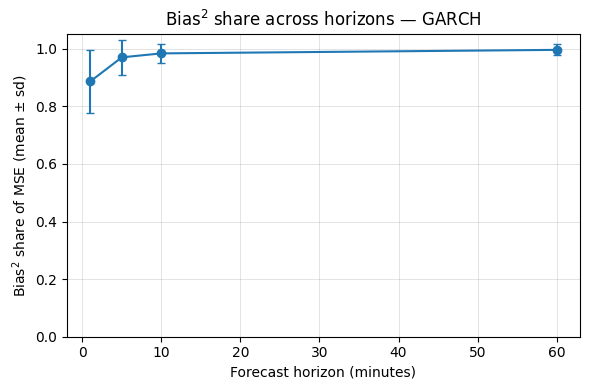

Saved: figures/bv_bias_share_garch.png


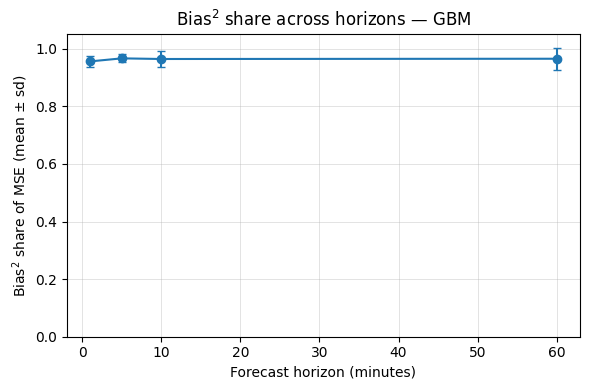

Saved: figures/bv_bias_share_gbm.png


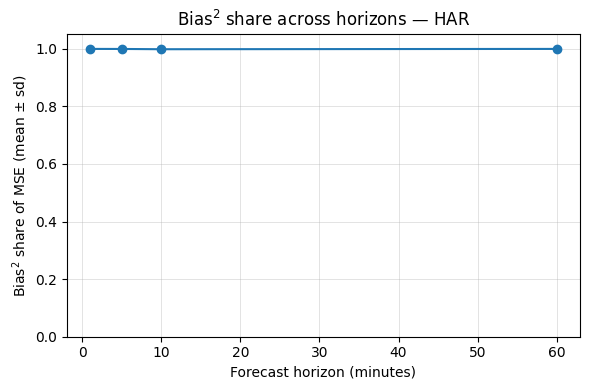

Saved: figures/bv_bias_share_har.png


In [8]:
for model in agg["model"].unique():
    sub = agg[agg["model"] == model].copy()
    x = sub["horizon"].values
    y = sub["bias_share_mean"].values
    yerr = sub["bias_share_std"].values

    plt.figure(figsize=(6, 4))
    plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=3)
    plt.xlabel("Forecast horizon (minutes)")
    plt.ylabel("Bias$^2$ share of MSE (mean ± sd)")
    plt.title(f"Bias$^2$ share across horizons — {model.upper()}")
    plt.ylim(0, 1.05)
    plt.grid(True, linewidth=0.5, alpha=0.5)
    outpath = fig_dir / f"bv_bias_share_{model}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

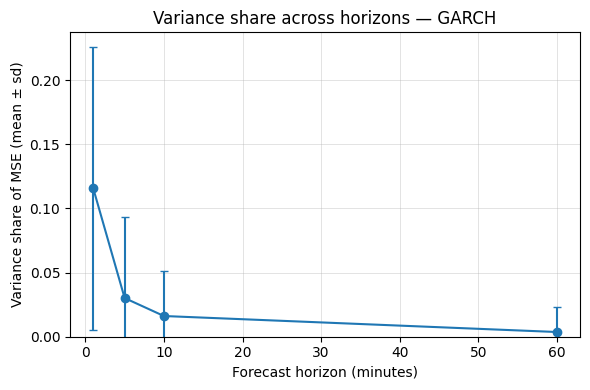

Saved: figures/bv_var_share_garch.png


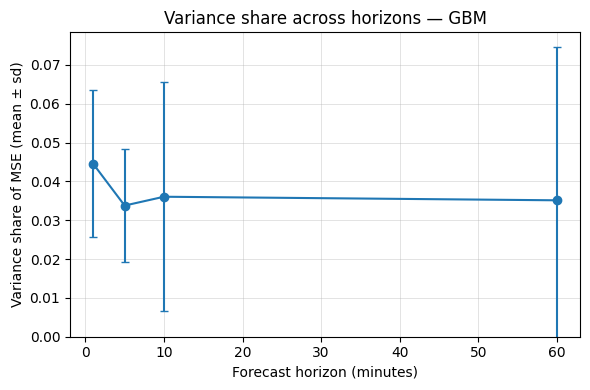

Saved: figures/bv_var_share_gbm.png


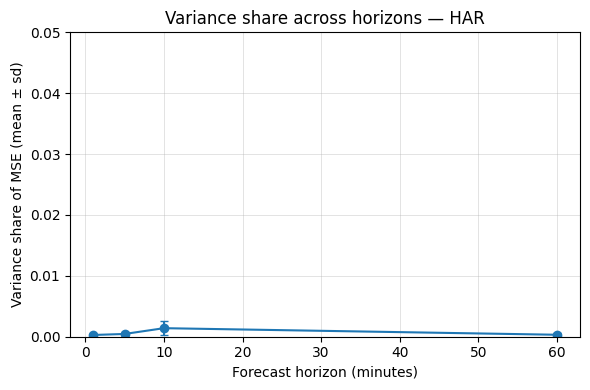

Saved: figures/bv_var_share_har.png


In [4]:
for model in agg["model"].unique():
    sub = agg[agg["model"] == model].copy()
    x = sub["horizon"].values
    y = sub["var_share_mean"].values
    yerr = sub["var_share_std"].values

    plt.figure(figsize=(6, 4))
    plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=3)
    plt.xlabel("Forecast horizon (minutes)")
    plt.ylabel("Variance share of MSE (mean ± sd)")
    plt.title(f"Variance share across horizons — {model.upper()}")
    # plt.yscale("log")
    plt.ylim(0, max(1.05 * (y + (yerr if np.all(np.isfinite(yerr)) else 0)).max(), 0.05))
    plt.grid(True, linewidth=0.5, alpha=0.5)
    outpath = fig_dir / f"bv_var_share_{model}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

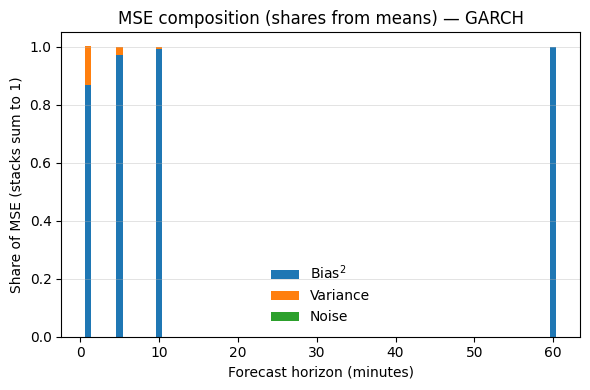

Saved: figures/bv_stacked_shares_garch.png


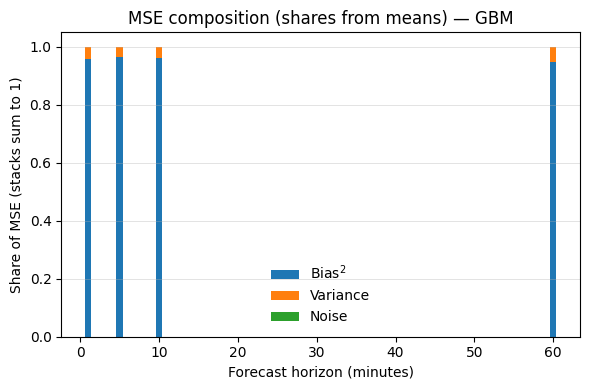

Saved: figures/bv_stacked_shares_gbm.png


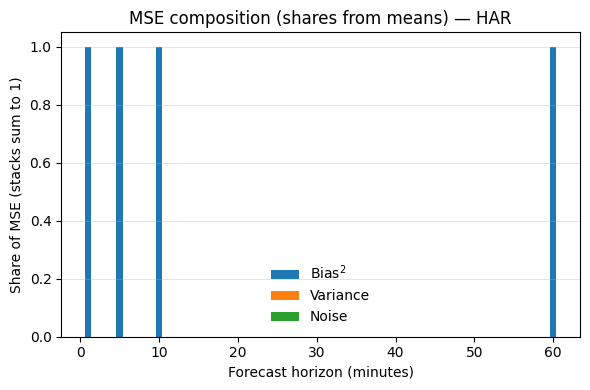

Saved: figures/bv_stacked_shares_har.png


In [5]:
for model in levels_agg["model"].unique():
    sub = levels_agg[levels_agg["model"] == model].copy()
    x = sub["horizon"].values.astype(float)
    width = np.diff(np.concatenate([x, [x[-1] + (x[-1]-x[-2] if len(x)>1 else 1)]])) * 0.6
    width = np.minimum(width, 0.8)
    
    bias = sub["bias2_share_from_means"].values
    var  = sub["var_share_from_means"].values
    noise = sub["noise_share_from_means"].values

    plt.figure(figsize=(6, 4))
    plt.bar(x, bias, width=width, label="Bias$^2$")
    plt.bar(x, var, width=width, bottom=bias, label="Variance")
    plt.bar(x, noise, width=width, bottom=bias+var, label="Noise")
    plt.xlabel("Forecast horizon (minutes)")
    plt.ylabel("Share of MSE (stacks sum to 1)")
    plt.title(f"MSE composition (shares from means) — {model.upper()}")
    plt.ylim(0, 1.05)
    plt.legend(frameon=False)
    plt.grid(True, axis='y', linewidth=0.5, alpha=0.5)
    outpath = fig_dir / f"bv_stacked_shares_{model}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=horizons, showfliers=False)


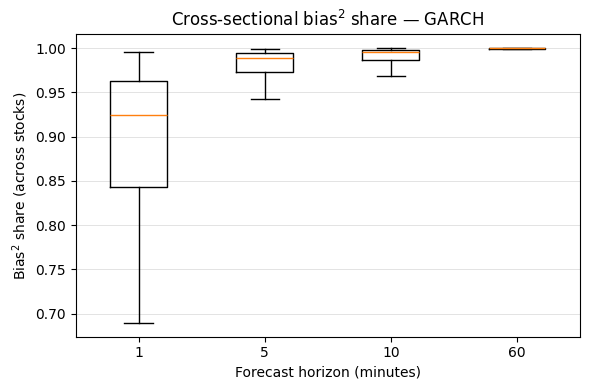

/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_var, labels=horizons, showfliers=False)


Saved: figures/bv_bias_share_boxplot_garch.png


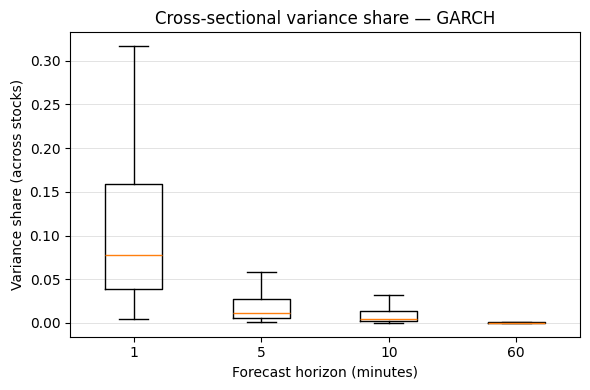

Saved: figures/bv_var_share_boxplot_garch.png


/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=horizons, showfliers=False)


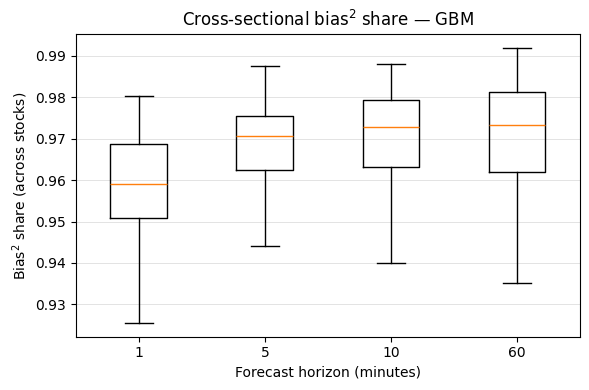

Saved: figures/bv_bias_share_boxplot_gbm.png


/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_var, labels=horizons, showfliers=False)


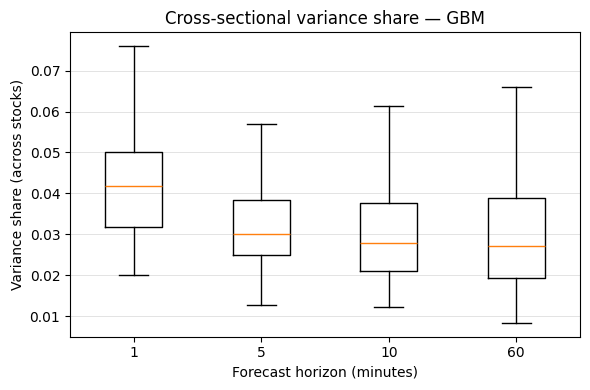

Saved: figures/bv_var_share_boxplot_gbm.png


/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=horizons, showfliers=False)


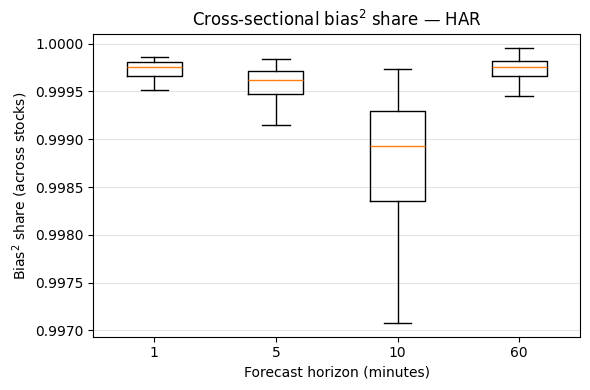

Saved: figures/bv_bias_share_boxplot_har.png


/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_13189/47458556.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_var, labels=horizons, showfliers=False)


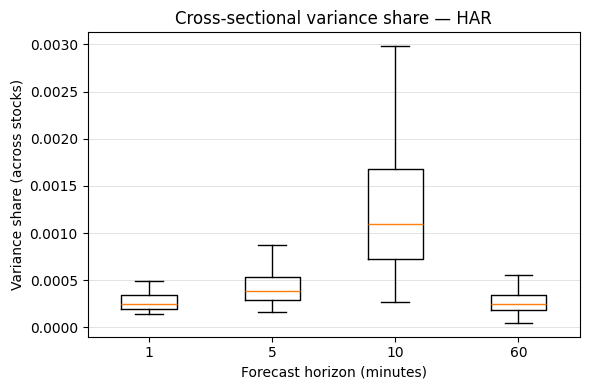

Saved: figures/bv_var_share_boxplot_har.png


In [6]:
for model in df["model"].unique():
    sub = df[df["model"] == model].copy()
    horizons = np.sort(sub["horizon"].unique())
    data = [sub.loc[sub["horizon"] == h, "bias_share"].values for h in horizons]

    plt.figure(figsize=(6, 4))
    plt.boxplot(data, labels=horizons, showfliers=False)
    plt.xlabel("Forecast horizon (minutes)")
    plt.ylabel("Bias$^2$ share (across stocks)")
    plt.title(f"Cross-sectional bias$^2$ share — {model.upper()}")
    plt.grid(True, axis='y', linewidth=0.5, alpha=0.5)
    outpath = fig_dir / f"bv_bias_share_boxplot_{model}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)

    data_var = [sub.loc[sub["horizon"] == h, "var_share"].values for h in horizons]
    plt.figure(figsize=(6, 4))
    plt.boxplot(data_var, labels=horizons, showfliers=False)
    plt.xlabel("Forecast horizon (minutes)")
    plt.ylabel("Variance share (across stocks)")
    plt.title(f"Cross-sectional variance share — {model.UPPER() if hasattr(model, 'UPPER') else model.upper()}")
    plt.grid(True, axis='y', linewidth=0.5, alpha=0.5)
    outpath = fig_dir / f"bv_var_share_boxplot_{model}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()
    print("Saved:", outpath)